In [1]:
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.model_selection import train_test_split
from dataset import TileDataset
from tqdm import tqdm
import torch
import os
from siamese_model import EmbeddingNetwork
import matplotlib.pyplot as plt

c:\Users\ssk48\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_embeddings():
    td = TileDataset("../dataset")
    model = EmbeddingNetwork()

    model_path_name = os.path.join("..", "models", "embedding_network.pth")

    weights = torch.load(model_path_name)
    model.load_state_dict(weights)
    model.eval()
    x_train = []
    y_train = []

    for i in tqdm(range(len(td))):
        img, label = td.__getitem__(i)
        embeddings = model(img.unsqueeze(0)).detach().numpy()

        x_train.append(embeddings)
        y_train.append(label)

    x_train = np.reshape(x_train, (-1, 128))
    np.save(os.path.join("..", "embeddings", "embeddings.npy"), x_train)
    np.save(os.path.join("..", "embeddings", "labels.py"), y_train)

In [16]:
x_train = np.load(os.path.join("..", "embeddings", "embeddings.npy"))
y_train = np.load(os.path.join("..", "embeddings", "labels.npy"))
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size=.2)
print(y_train.shape)
print(x_train.shape)
train_classes = set(list(np.unique(y_train)))
x_train_synth_ex = []
y_train_added_labels = []
for index in range(len(y_train)):
    if y_test[index] not in train_classes:
        train_classes.add(y_test[index])
        x_train_synth_ex.append(x_test[index])
        y_train_added_labels.append(y_test[index])

x_train = np.append(x_train, np.asarray(x_train_synth_ex), axis = 0)
y_train = np.append(y_train, y_train_added_labels)
print(x_train.shape)
print(y_train.shape)

IndexError: index 20260 is out of bounds for axis 0 with size 20260

In [11]:
from sklearn.metrics import f1_score
def get_top_k_acc(clf, k):
    num_correct = 0
    for feat, label in tqdm(zip(x_test, y_test)):
        probs = clf.predict_proba(feat.reshape(1, -1))[0]
        indices = np.argsort(probs)[::-1]
        top_k_labels = clf.classes_[indices[:k]]
        if label in top_k_labels:
            num_correct += 1
    return num_correct / len(x_test)

def get_f1_score(clf, x, y_true):
    y_pred = clf.predict(x)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

def evaluate_model(clf, k, train=True, test=True, top_k=True):
    train_f1, test_f1, top_k_acc = None, None, None
    if train:
        train_f1 = get_f1_score(clf, x_train, y_train)
    if test:
        test_f1 = get_f1_score(clf, x_test, y_test)
    if top_k:
        top_k_acc = get_top_k_acc(clf, k)
    return train_f1, test_f1, top_k_acc

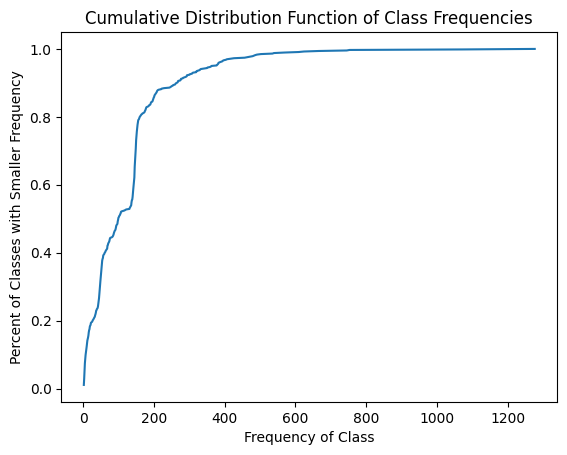

In [6]:
vals, freqs = np.unique(y_train, return_counts=True)

x, counts = np.unique(freqs, return_counts=True)
cusum = np.cumsum(counts)
plt.plot(x, cusum/ cusum[-1])
plt.xlabel("Frequency of Class")
plt.ylabel("Percent of Classes with Smaller Frequency")
plt.title("Cumulative Distribution Function of Class Frequencies")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=2, max_features ="log2", random_state=0)
clf.fit(x_train, y_train)

train_f1, test_f1, _ = evaluate_model(clf, 5, x_train, y_train, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

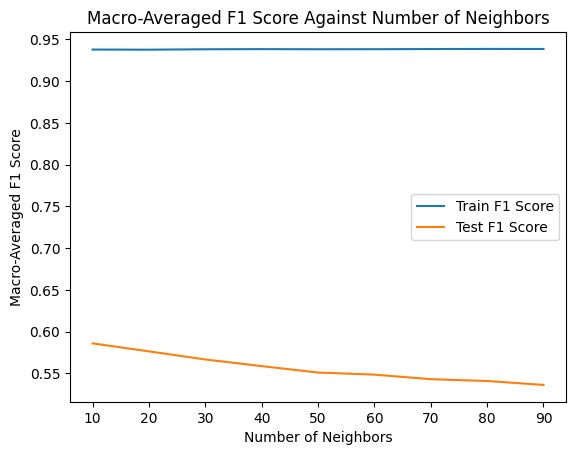

In [12]:
from sklearn.neighbors import KNeighborsClassifier
train_f1s = []
test_f1s = []
n_neighbors_range = range(10, 100, 10)
for n_neighbors in n_neighbors_range:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance", metric="cosine")
    clf.fit(x_train, y_train)
    train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

plt.plot(n_neighbors_range,
         train_f1s)
plt.plot(n_neighbors_range,
         test_f1s)
plt.xlabel("Number of Neighbors")
plt.ylabel("Macro-Averaged F1 Score")
plt.title("Macro-Averaged F1 Score Against Number of Neighbors")
plt.legend(["Train F1 Score", "Test F1 Score"])

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

c:\Users\ssk48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train F1 Score: 0.2520568743140576
Test F1 Score: 0.2619235503911677


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(x_train, y_train)


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (64, 64), max_iter = 1000, n_samples=100, random_state=1)
clf.fit(x_train, y_train)


In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=25, random_state=0)
clf.fit(x_train, y_train)
train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

Train F1 Score: 0.9187353621034196
Test F1 Score: 0.5947388393316027


In [ ]:
clf = LinearSVC()
clf.fit(x_train, y_train)

train_f1, test_f1, _ = evaluate_model(clf, 5,  top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

In [ ]:
import pickle
clf_model_path = os.path.join("..", "models", "model.pkl")
with open(clf_model_path ,'wb') as f:
    pickle.dump(clf,f)